# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** 50  
**Kaggle challenge:** Classic  
**Kaggle team name (exact):** "ChocoBlabla"  

**Author 1 (SCIPER):** *Louis Cuendet (xxxxxx)*  
**Author 2 (SCIPER):** *Timur Ünver (341178)*  
**Author 3 (SCIPER):** *Adrien Boschung (327221)*  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

In [104]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

path_ref = 'C:/Users/timur/OneDrive/Documents/GitHub/iapr_group_50/project/dataset_project_iapr2025/train'
jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:/Users/timur/OneDrive/Documents/GitHub/iapr_group_50/project/dataset_project_iapr2025/train'

## Segmentation

### Background classification

### Chocolate classification

Once one knows which background we are dealing with, we use the according segmentation function to isolate the chocolates of the image.

#### Simple background classification

The first and simplest segmentation comes from the processing of the white background. We define the following function:

In [ ]:
def segmentation_clean_background(img, plot_edges=False, plot_closed=False, plot_mask=False):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to Grayscale ---
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # --- 3. Blur to Reduce Noise ---
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(blurred, threshold1=20, threshold2=50)
    if plot_edges:
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')
        plt.show()

    # --- 5. Dilate to Connect Broken Edges ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # --- 6. Morphological Closing to Fill Gaps ---
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)
    if plot_closed:
        plt.imshow(closed, cmap='gray')
        plt.title('Morphological Closing')
        plt.axis('off')
        plt.show()

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Skip tiny noise
        if area < 2000:
            if len(cnt) >= 5:
                ellipse = cv2.fitEllipse(cnt)
                (x, y), (MA, ma), angle = ellipse
                if MA > 5 and ma > 5:
                    cv2.ellipse(mask, ellipse, 255, -1)
        else:
            # If not enough points, fall back to filled contour
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    if plot_mask:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask after Area Filtering')
        plt.axis('off')
        plt.show()

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    return segmented_objects

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    plt.show()


We first convert the rgb image to grayscale values and then apply gaussian blurring to remove any potential noise. Using fine tuned values on the training dataset, we managed to find Canny filter thresholds 20 and 50 for this specific background.
This gives us images like these:

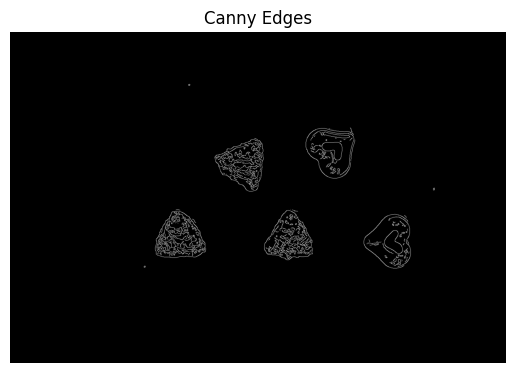

In [ ]:
img_path = os.path.join(path_ref, jpg_files[2])
img = mpimg.imread(img_path)
seg = segmentation_clean_background(img, plot_edges=True)

Knowing the edges one can now apply a dilation to connect them and apply a morphological closing to obtain clean contours:

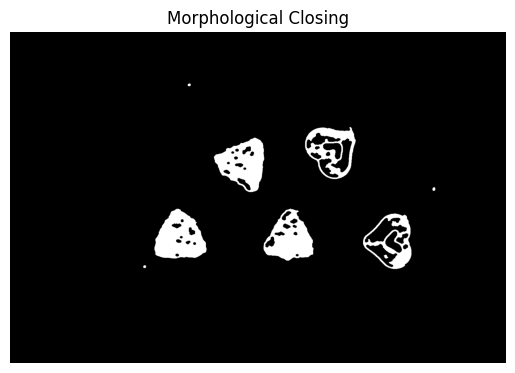

In [ ]:
seg = segmentation_clean_background(img, plot_closed=True)

At this point the chocolates aren't connected shapes yet. CV2 allows filling of the interior of contours using cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED). Having made them more visible we can apply the function and get a clear mask of the chocolates:

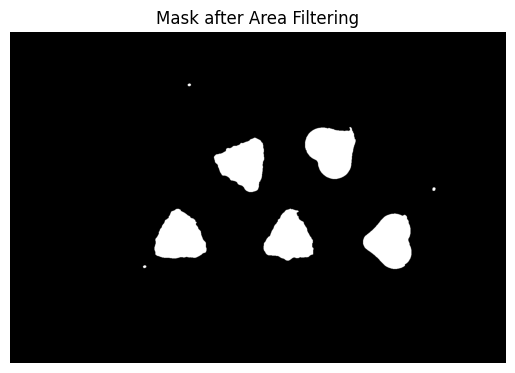

In [ ]:
seg = segmentation_clean_background(img, plot_mask=True)

We have also implemented an ellipse interpolation for this type of background. In fact as jelly white chocolates contours can be a bit more difficult to close entirely, we complete it by using an ellipse on the whole shape. 
This results in an overall good performance for the testing and training sets however this needs some attention for other backgrounds segmentation as it can model noise.

Finally one can apply the mask on the image to conclude the segmentation. Here are a couple of examples:

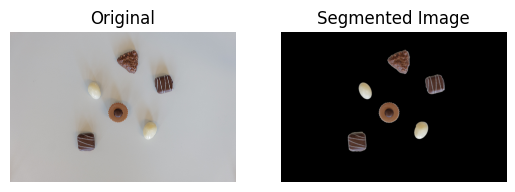

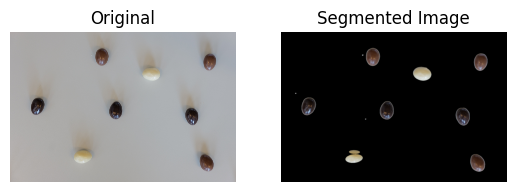

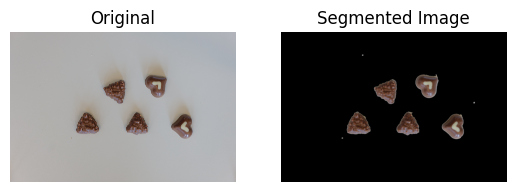

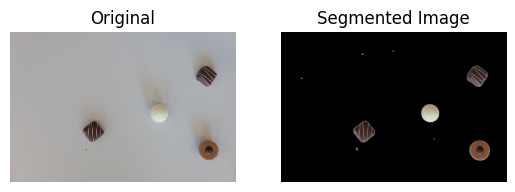

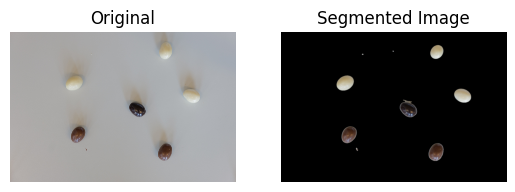

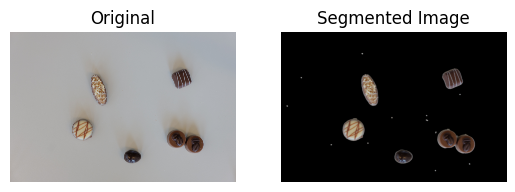

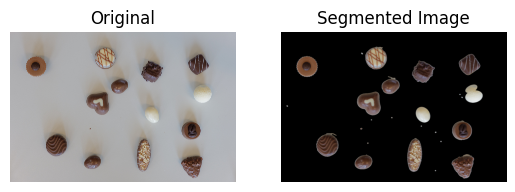

In [ ]:
for i in range(0, 7):
    img_path = os.path.join(path_ref, jpg_files[i])
    img = mpimg.imread(img_path)
    seg = segmentation_clean_background(img)
    show_comparison(img, seg, 'Segmented Image')

The performance of the segmentation is rather good but some post-processing such as morphological openings to clean shapes and watersheds to separate close chocolates will be done during the classification phase.

#### Other background segmentations

Some other backgrounds segmentations such as the one for the "orange book" can be a bit more complex to implement. Using a basic thresholding or Canny filter will result in an oversegmentation with too many objects.

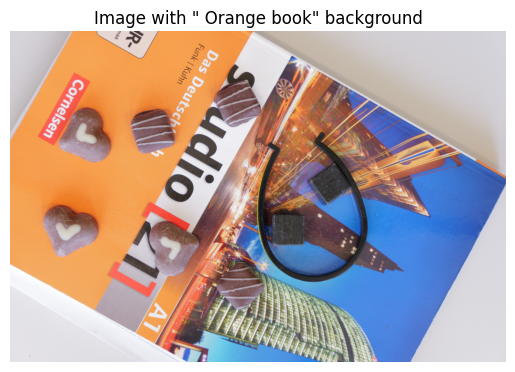

In [ ]:
img = cv2.imread(os.path.join(path_ref, jpg_files[71]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Image with \" Orange book\" background')
_ = plt.axis('off')

We therefore define an additional segmentation function for this function as shown below:

In [ ]:
def segmentation_orange_book(img, plot_dilated=False, plot_mask=False, plot_mask_closed=False, plot_mask_opened=False):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
    value = hsv[:, :, 2]

    # Gaussian blur to reduce noise
    value = cv2.GaussianBlur(value, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(value, 50, 100)

    # --- 5. Dilate to Connect Broken Edges ---
    radius = 2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    if plot_dilated:
        plt.imshow(dilated, cmap='gray')
        plt.title('Dilated Edges')
        plt.axis('off')
        plt.show()

    # --- 6. Remove small objects ---

    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated, connectivity=8)

    # Set a minimum size threshold (in pixels)
    min_size = 2000

    # Create output image
    output = np.zeros(dilated.shape, dtype=np.uint8)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255

    contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(dilated)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 30000:  # adjust the area threshold as needed
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    
    if plot_mask:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask after Area Filtering')
        plt.axis('off')
        plt.show()

    # Close objects
    radius = 4
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    if plot_mask_closed:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask after Morphological Closing')
        plt.axis('off')
        plt.show()

    # Separate objects
    radius = 40
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    if plot_mask_opened:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask after Morphological Opening')
        plt.axis('off')
        plt.show()

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    return segmented_objects

The structure of this function is quite similar to the previous one. However we are now using HSV images instead of RGB. HSV images tend to be better for separation as the hue and saturation channels can describe colors independently of lighting (in the value channel). By comparing the 3 channels, the contours are usually more visible on the value one as it contains information about shadows:

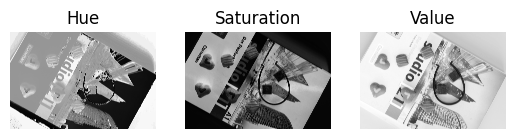

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.imshow(hsv[:, :, 0], cmap='gray')
ax1.set_title('Hue')
ax1.axis('off')
ax2.imshow(hsv[:, :, 1], cmap='gray')
ax2.set_title('Saturation')
ax2.axis('off')
ax3.imshow(hsv[:, :, 2], cmap='gray')
ax3.set_title('Value')
ax3.axis('off')
plt.show()

As before, we defined the appropriate thresholds for the Canny filter which results in visible contours for most objects:

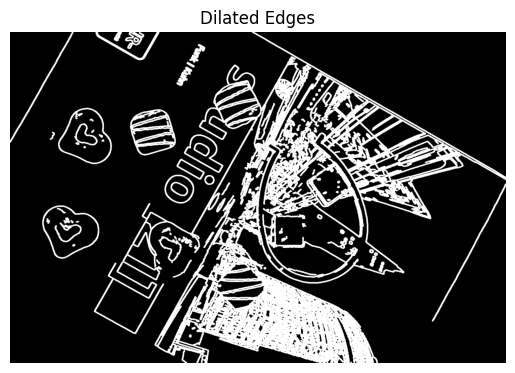

In [ ]:
seg = segmentation_orange_book(img, plot_dilated=True)

As it can be seen, the "Amandina" chocolate here gets blended with the background. In our case this is the main disadvantage of using lighting for this method as the inner pattern of the chocolate gets confused. 
Nonetheless if the shape is closed, the object is segmented correctly:

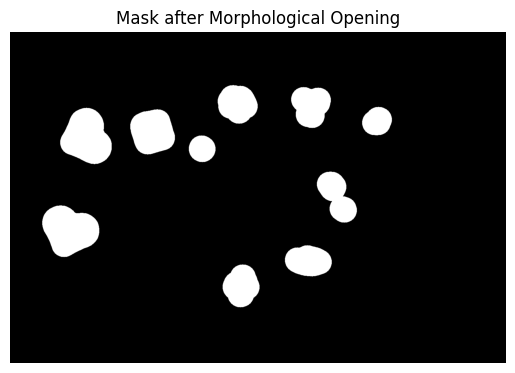

In [ ]:
seg = segmentation_orange_book(img, plot_mask_opened=True)

Which gives us the following segmentation:

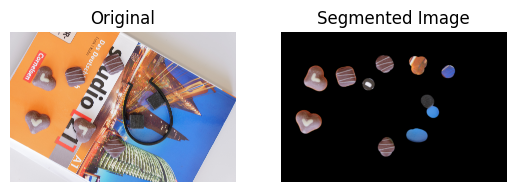

In [ ]:
seg = segmentation_orange_book(img)
show_comparison(img, seg, 'Segmented Image')

Some noise was segmented but the classifier considers the size and discards too small chocolates. However it is still not perfect. Color should also be considered as an "outlier" criteria.

## Classification

In this section, we will detail which chocolate descriptors we decide to keep or not for classification and the reasons why.

The first important note is that the descriptors were computed on the reference images. We did not take into account other chocolates from the train dataset as we developed segmentation and classification in parallel and it was therefore easier to develop classification regarding the reference images that were much easier to segment. An improvement to our classification would be to average the chocolate descriptors accross the train set which would most probably yield a better result on the test set.


Our first idea was to first clusterize the chocolates in different categorize related to their shapes. To do so we decided to compute the Fourier descriptors as they worked well during the labs. 

In [90]:
# IMPORTS FROM LABS #
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation, binary_erosion, binary_closing
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours
from skimage.feature import canny
from skimage import io, color
from skimage import segmentation, measure, exposure

import cv2 # are we allowed?
import numpy as np

import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

In [91]:
path_train_adri = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/dataset_project_iapr2025/train' 
jpg_files = [f for f in os.listdir(path_train_adri)]
n_images = len(jpg_files)

In [92]:
patterns = []
import os
import matplotlib.image as mpimg
import numpy as np
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
import nbimporter
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation, binary_erosion, binary_closing

import reference_segmentation as rs
import segmentation_clean_background as scb

path_ref = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/dataset_project_iapr2025/references' 

jpg_files = [f for f in os.listdir(path_ref) if f.lower().endswith(".jpg")]
n_images = len(jpg_files)

loaded_images = []
cropped_isolated_imgs = []

for i in range(n_images):
    img_path = os.path.join(path_ref, jpg_files[i])
    img = mpimg.imread(img_path)
    res = scb.segmentation(img)  # segmentation result

    # Keep the full original image for later masking
    img_ref = img.copy()
    img_ref = cv2.resize(img_ref, (1600,1067))
    # Threshold the result to create a binary mask
    masked_img = np.mean(res, axis=2) > 0
    
    # Label connected components
    labeled_mask = label(masked_img)
    regions = regionprops(labeled_mask)

    if not regions:
        continue  # skip if no region found

    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        isolated_mask = labeled_mask == region.label

        # Crop both the mask and the image to match
        img_crop = img_ref[minr-1:maxr+1, minc-1:maxc+1]
        mask_crop = isolated_mask[minr-1:maxr+1, minc-1:maxc+1]

        # Apply mask to the cropped image
        isolated_img = np.zeros_like(img_crop)
        isolated_img[mask_crop] = img_crop[mask_crop]

        if i not in [7,11]:
            footprint = disk(30)
            if i in [1,8] :
                footprint = disk(60)
            # Step 1: Smooth the binary mask
            smoothed_mask = opening(mask_crop, footprint=footprint)

            # Step 2: Apply the smoothed mask to the original cropped RGB
            isolated_img = np.zeros_like(img_crop)
            for c in range(3):
                isolated_img[..., c] = img_crop[..., c] * smoothed_mask

        # plt.figure()
        # plt.imshow(isolated_img)
        # plt.show()
        patterns.append(isolated_img)

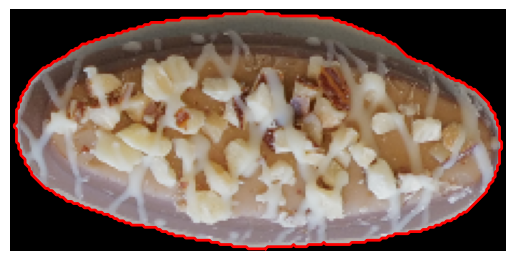

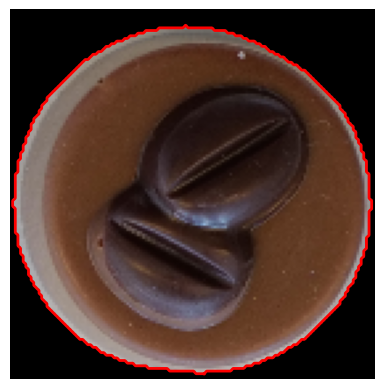

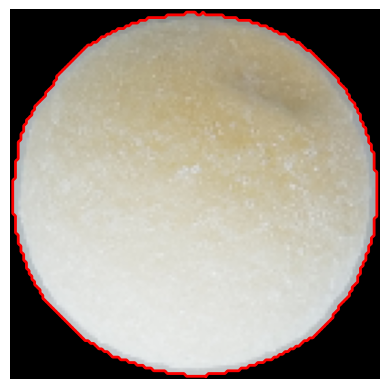

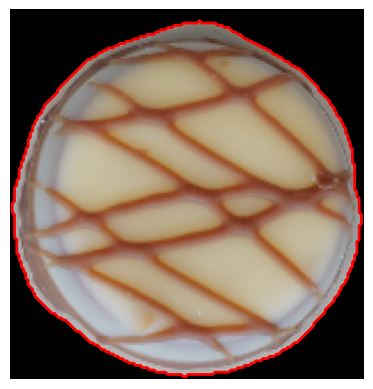

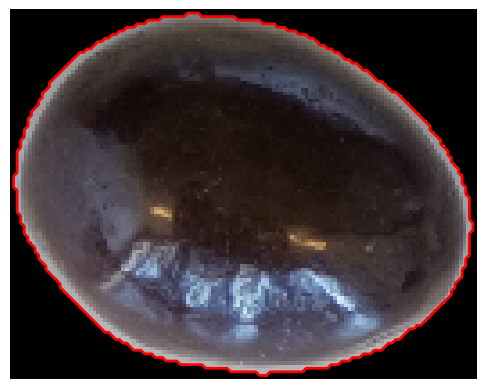

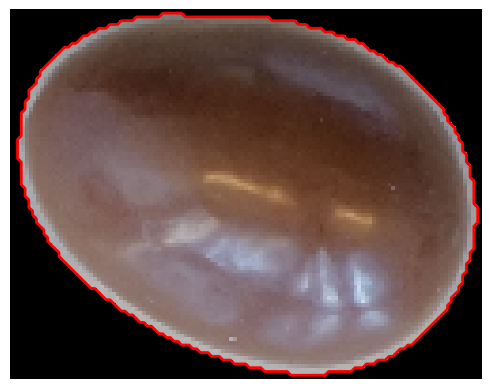

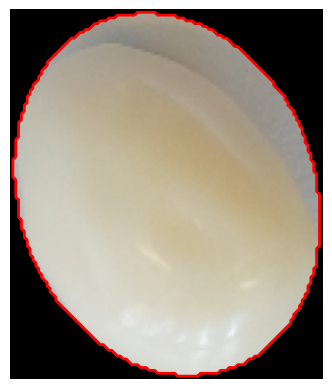

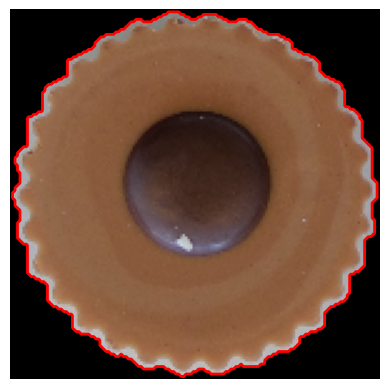

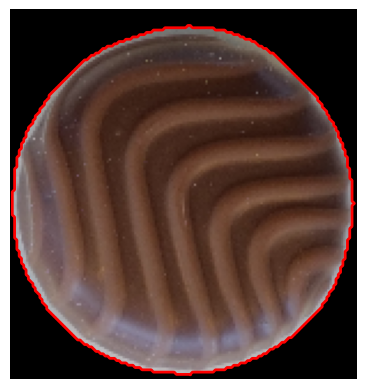

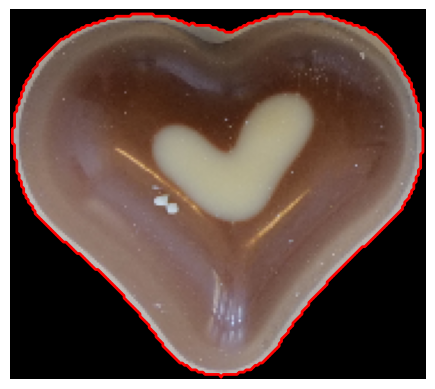

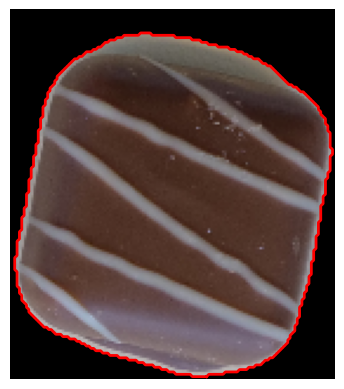

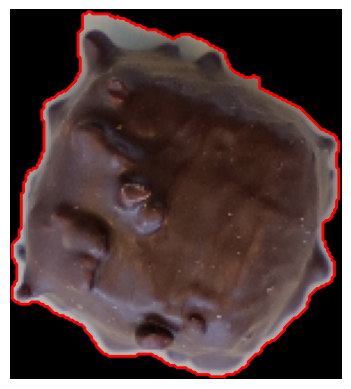

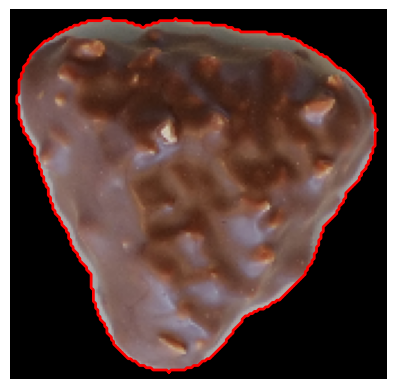

In [93]:
# Contours
contours_patterns = []

def contour_of_patterns(patterns):
    contours_patterns = []
    for i in range(len(patterns)):
        if i < n_images:
            plt.figure()
            img = patterns[i]
            img = np.array(img)
            img = np.mean(img, axis=2)
            binary = img > 0 
            contours = find_contours(binary, level=0.5)
            if contours:
                contour = np.fliplr(max(contours, key=lambda x: x.shape[0]))
                contours_patterns.append(contour)
                plt.imshow(patterns[i], cmap='gray')
                plt.axis('off')
                plt.plot(contour[:, 0], contour[:, 1], linewidth=2, color='red')  # use [:, 0] and [:, 1]
        else:
            ax.axis('off')  # Hide empty subplots

    return contours_patterns

contours_patterns = contour_of_patterns(patterns)

In [94]:
def compute_descriptor_padding(contours: np.ndarray, n_samples: int = 9):
    """
    Compute Fourier descriptors of input images
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider. If the contour length is higher, discard the remaining part. If it is shorter, add padding.
        Make sure that the first element of the descriptor represents the continuous component.

    Return
    ------
    descriptors: np.ndarray complex (N, n_samples)
        Computed complex Fourier descriptors for the given input images
    """

    N = len(contours)
    # Look for the number of contours
    descriptors = np.zeros((N, n_samples), dtype=np.complex128)

    # ------------------
    for i in range(N):
        contour = contours[i]
        if len(contour) > n_samples:
            contour = contour[:n_samples]
        elif len(contour) < n_samples:
            contour = np.concatenate((contour, np.zeros((n_samples - len(contour), 2))), axis=0)
        descriptors[i, :] = np.fft.fft(contour[:, 0] + 1j * contour[:, 1], n_samples, axis=0)
    # ------------------

    return descriptors

def linear_interpolation(contours: np.ndarray, n_samples: int = 9):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    # ------------------
    for i in range(N):
        # Get the contour to process
        contour = contours[i]
        # Compute the distance between points
        dist = np.sqrt(np.sum(np.diff(contour, axis=0) ** 2, axis=1))
        # Compute the cumulative distance
        cum_dist = np.concatenate(([0], np.cumsum(dist))) #with initial point at 0
        # Interpolate the points
        dist = np.linspace(0, cum_dist[-1], n_samples) #defining the distance axis (from 0 to the total distance at [-1] index)
        x_interp = np.interp(dist, cum_dist, contour[:, 0]) #x as a function of distance
        y_interp = np.interp(dist, cum_dist, contour[:, 1]) #y as a function of distance
        contours_inter[i] = np.array([x_interp, 
                                      y_interp]).T #transposing to get the right shape
                                      
    # ------------------
        
    return contours_inter

def translation_invariant(features):
    """
    Make input Fourier descriptors invariant to translation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to translation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    features_inv[:,1:] = features[:,1:]
    # ------------------
    
    return features_inv

def rotation_invariant(features):
    """
    Make input Fourier descriptors invariant to rotation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to rotation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    features_inv = np.abs(features)
    # ------------------
    
    return features_inv

def normalize_descriptors(descriptors):
    normalized = []
    for des in descriptors:
        # Remove the DC component (translation invariance)
        des[0] = 0
        # Scale invariance
        des = des / np.abs(des[1])
        # Use only magnitudes (rotation invariance)
        normalized.append(np.abs(des))
    return np.array(normalized)

In [109]:
contours_patterns = linear_interpolation(contours_patterns, n_samples = 150)
descriptors = translation_invariant(rotation_invariant(compute_descriptor_padding(contours_patterns)))
normalized_descriptors = normalize_descriptors(descriptors)

# For the different shapes we average the descriptors
correct_labels = [0,1,1,1,2,2,2,1,1,4,3,3,4]

correct_labels = np.array(correct_labels)
unique_classes = np.unique(correct_labels)
mean_descriptors = {}

# Compute the mean descriptors for each class
for class_label in unique_classes:
    indices = np.where(correct_labels == class_label)[0]
    mean_descriptors[class_label] = np.mean(normalized_descriptors[indices], axis=0)


Now we will plot the mean Fourier descriptors:

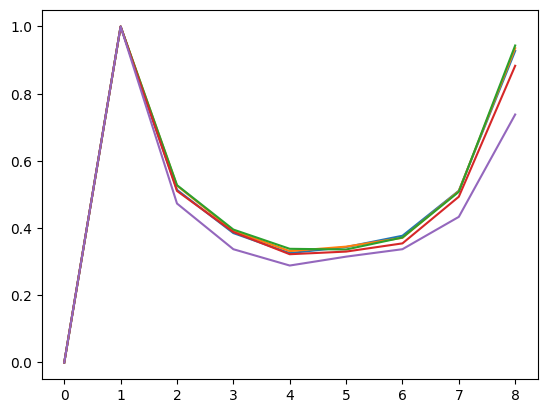

In [110]:
plt.figure()
for d in mean_descriptors:
    plt.plot(mean_descriptors[d])

We see that the descriptors are very similar are therefore very hard to differentiate. They worked better in the labs as the numbers we were trying to retrieve were very different but in our case, the shape are similar and irregularities/inconsistencies in segmentation can easily lead in differences in the Fourier descriptor that will prevent us from correctly classifying the chocolate. For these reasons (and after testing on different chocolates of the train set) we decided to drop Fourier descriptors and focus on other features that are more insightful.

To further show you the similarities between the shapes, we computed how similar shapes are relative to each other:

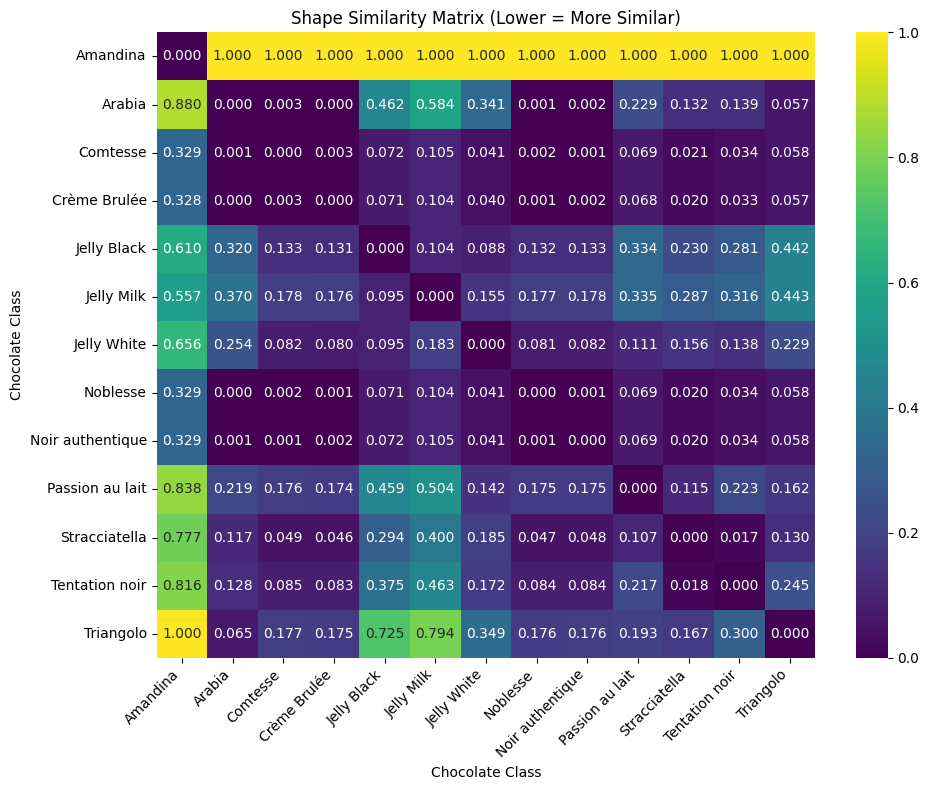

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def to_cv2_contour(contour):
    return contour.reshape((-1, 1, 2)).astype(np.float32)

def plot_sim_matrix() :
    # Convert all contours to OpenCV format
    cv2_contours = [to_cv2_contour(c) for c in contours_patterns]

    # Create similarity matrix
    n = len(cv2_contours)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = cv2.matchShapes(cv2_contours[i], cv2_contours[j], cv2.CONTOURS_MATCH_I1, 0)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(similarity_matrix)    

    choco_names = [
        "Amandina", "Arabia", "Comtesse", "Crème Brulée", "Jelly Black", "Jelly Milk", "Jelly White",
        "Noblesse", "Noir authentique", "Passion au lait", "Stracciatella", "Tentation noir", "Triangolo"
    ]

    plt.figure(figsize=(10, 8))
    sns.heatmap(scaled, xticklabels=choco_names, yticklabels=choco_names, cmap='viridis', annot=True, fmt=".3f")
    plt.title("Shape Similarity Matrix (Lower = More Similar)")
    plt.xlabel("Chocolate Class")
    plt.ylabel("Chocolate Class")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return

plot_sim_matrix()

We see that chocolates are close to each other except for amandina and triangolo. For amandina there is another feature that we will develop later which already strongly differentiate amandina from the rest. In general, we decided to not use the Fourier descriptors due to imperfections in segmention which negatively impacts the Fourier descriptors and their use for segmentation.

Even though shapes are not useful by themselves, other geometric features are. By investigating them we found a few that successfully cluster the chocolates in three different categories. The 1st one is the compacity:

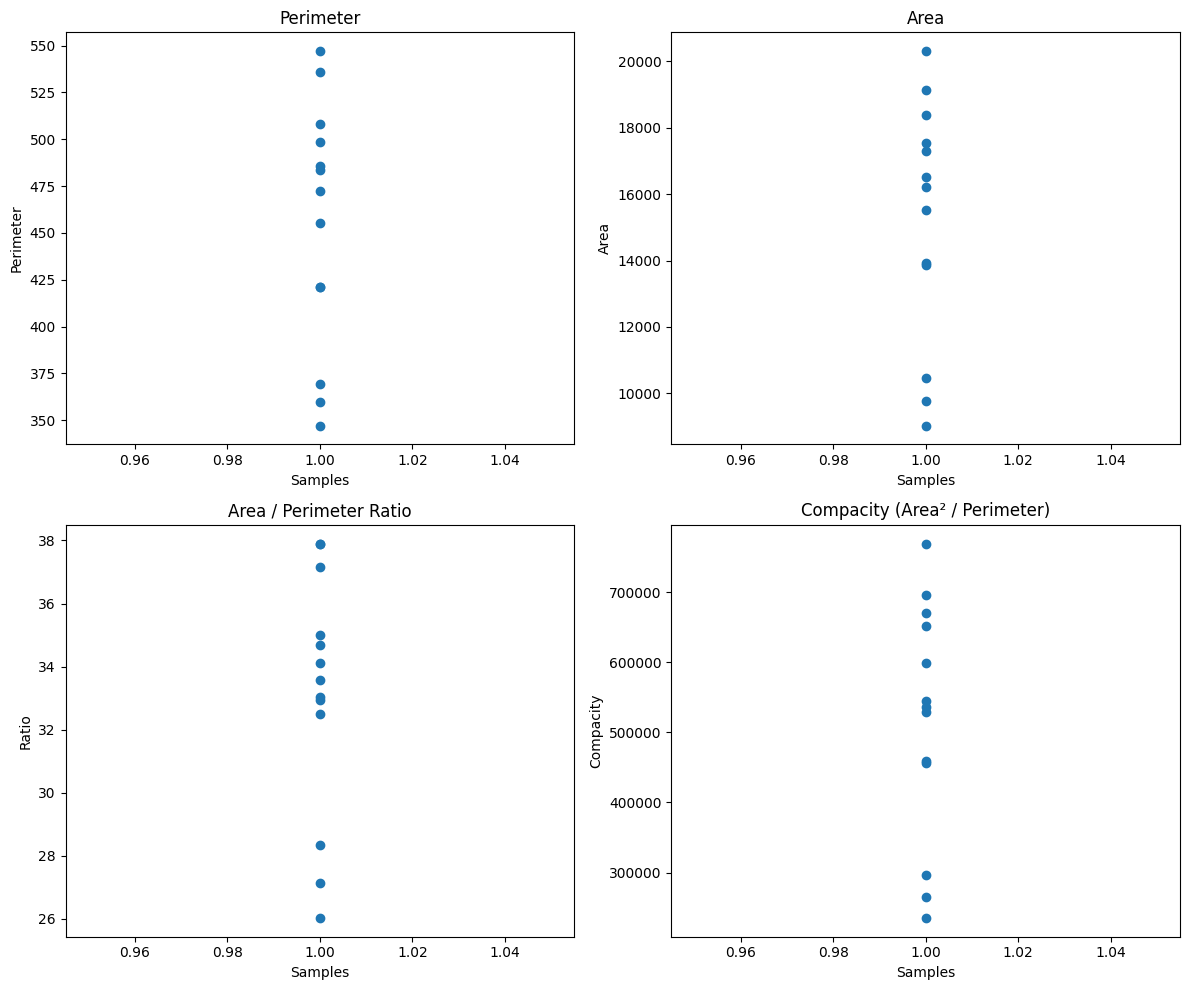

In [98]:
def find_clusters(contours_patterns) :
    areas = []
    perimeters = []
    ratio = []
    compacity = []
    
    for contour in contours_patterns:
        contour = contour.astype(np.float32)
        areas.append(cv2.contourArea(contour))
        perimeters.append(cv2.arcLength(contour, closed=True))
        ratio.append(cv2.contourArea(contour)/cv2.arcLength(contour, closed=True))
        compacity.append(cv2.contourArea(contour)**2/cv2.arcLength(contour, closed=True))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Perimeters
    axes[0, 0].plot([1]*len(perimeters), perimeters, 'o')
    axes[0, 0].set_title("Perimeter")
    axes[0, 0].set_xlabel("Samples")
    axes[0, 0].set_ylabel("Perimeter")

    # Areas
    axes[0, 1].plot([1]*len(areas), areas, 'o')
    axes[0, 1].set_title("Area")
    axes[0, 1].set_xlabel("Samples")
    axes[0, 1].set_ylabel("Area")

    # Ratio
    axes[1, 0].plot([1]*len(ratio), ratio, 'o')
    axes[1, 0].set_title("Area / Perimeter Ratio")
    axes[1, 0].set_xlabel("Samples")
    axes[1, 0].set_ylabel("Ratio")

    # Compacity
    axes[1, 1].plot([1]*len(compacity), compacity, 'o')
    axes[1, 1].set_title("Compacity (Area² / Perimeter)")
    axes[1, 1].set_xlabel("Samples")
    axes[1, 1].set_ylabel("Compacity")

    plt.tight_layout()
    plt.show()
    
    return areas, perimeters, ratio, compacity

areas, perimeters, ratio, compacity = find_clusters(contours_patterns)

We see on the compacity plot that we can extract two distinct clusters. Chocolates with a compacity higher and lower than approximately 320'000. The 3 low compacity chocolates are the 3 Jelly's (Cluster 2). This is a good cluster as we can easily differentiate the Jelly chocolates by their RGB colors which we will show later.
Now we want to investigate if we can find another feature to further separate the bigger cluster of 10 chocolates. 

In [99]:
cluster1 = []
cluster2 = []
for i in range(len(ratio)):
    if compacity[i] > 320000 :
        cluster1.append(i)
        continue
    else :
        cluster2.append(i)

print(cluster1)
print(cluster2)

[0, 1, 2, 3, 7, 8, 9, 10, 11, 12]
[4, 5, 6]


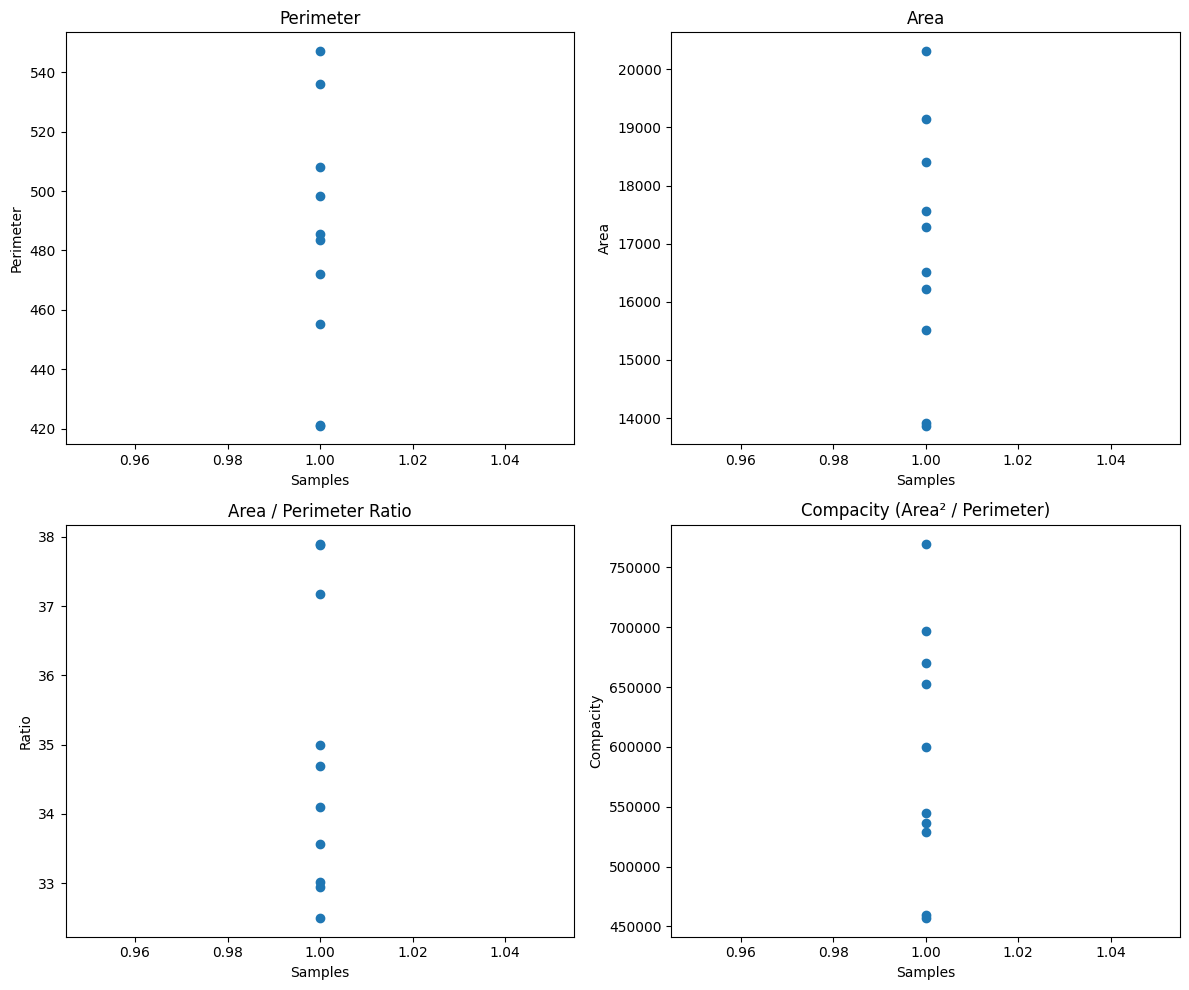

In [100]:
areas1, perimeters1, ratio1, compacity1 = find_clusters([contours_patterns[i] for i in cluster1])

On these graphs specific to the first cluster we see another feature that can clusterize the chocolates which is the ratio of the area over the perimeter. It separates high ratio chocolates (Cluster 1.1 : Crème Brulée, Noir authentique and Passion au lait) from the low ratio chocolates (CLuster 1.2 : Amandina, Arabia, Comtesse, Noblesse, Straciatella and Triangolo). These cluster seem good as each chocolates is quite different from each other.

We will of course use color features (RGB) as well as HSV because they are basic features that have different values for different chocolates.

For each cluster, we build a different KNN classifier with the features extracted from the reference images and that we considered to be useful for that specific cluster.

#### <span style="color:chartreuse;">CLuster 1.1 :</span>

This cluster contains Crème Brulée, Noir authentique and Passion au lait.

For this cluster we decided to use the following features: 
- RGB 
- HSV 
- Contrast
- Stripe detection
- Perimeter
- Area
- Circularity

For this cluster, we observed surprising behavior. The performance on the train set was the highest when the only features used to differentiate them was the RGB values (no HSV nor contrast nor stripe detection) and then we tried to add perimeter, area and circularity which slightly improved performance. This is surprising, especially for HSV as the 3 chocolates have very different HSV values.

When fine tuning the classification, we observed that sometimes Triangolo's would be clusterized in 1.1 instead of 1.2. When adding Triangolo to 1.1 (and keeping it in 1.2 at the same time) we obtained better results. We do not think it is an issue to have a chocolate in both clusters as the other descriptors are different and will not lead to major misclassifications.

#### <span style="color:chartreuse;">CLuster 1.2 :</span>

This cluster contains Amandina, Arabia, Comtesse, Noblesse, Straciatella, Tentation noir and Triangolo.

For this cluster we decided to use the following features: 
- RGB 
- HSV 
- Texture
- Rectangularity
- Contrast
- Stripe detection

Stripe detection was used to classify Straciatella's as it contains white stripes. When classifying it in the KNN it led to some misclassification with Tentation noir and Arabia (but they have no stripes). This improved our performance on the train set. 

The rectangularity feature was used to try to differentiate the triangolo and tentation noir from the circular chocolates. We wanted looked into ways of quantifying triangularity such as peaks detection but it was hard to extract specific values for triangolo out of them (segmentation and other issues).

Contrast results in a wide range of values for the chocolates and was therefore deemed as a performant feature for the KNN.

A possible improvement would be to add the feature circularity to this cluster too as it contains both circular and non-circular chocolates.

#### <span style="color:chartreuse;">CLuster 2 :</span>

This cluster contains Jelly White, Jelly Milk and Jelly Black.

For this cluster we decided to use the following features: 
- RGB 
- HSV 
- Contrast

Jelly's all have the same shape so geometrical features will not be relevant in this case.
On the other hand they all have distinct colors so RGB and HSV are almost sufficient to classify them with high accuracy.
We also added contrast to add a new dimension to the KNN but the performance did not change.

#### <span style="color:yellow;">Implementations for special cases :</span> 

<span style="color:orange;">Black boxes and magnets</span> : 

In the images there are some objects (black items and magnets) that have a similar size and shape as the chocolates that we want to identify. To try to recognize them and ignore them we sampled their RGB values in the train set and if the the object we are trying to classify has an RGB too close to these, we ignore it. This improved our performance significantly. It might be interesting to take more features into account when detecting those unwanted objects (for further improvment).

<span style="color:orange;">Smoothing chocolates</span> :

It oftens happens that part of the shadow (or other irregularities) is included in the cropped out chocolate. In this case smoothing (more specifically opening) the cropped out chocolate can help to erase this unwanted feature and help correctly classify the chocolates. It also improved performance.

In [101]:
# Apply opening to smoothen the contour
footprint = disk(15)
smoothed_mask = opening(mask_crop, footprint=footprint)
isolated_img = np.zeros_like(img_crop)
for c in range(3):
    isolated_img[..., c] = img_crop[..., c] * smoothed_mask

By applying this code snippet  it changes the shapes as follows (for this kind of irregularity):

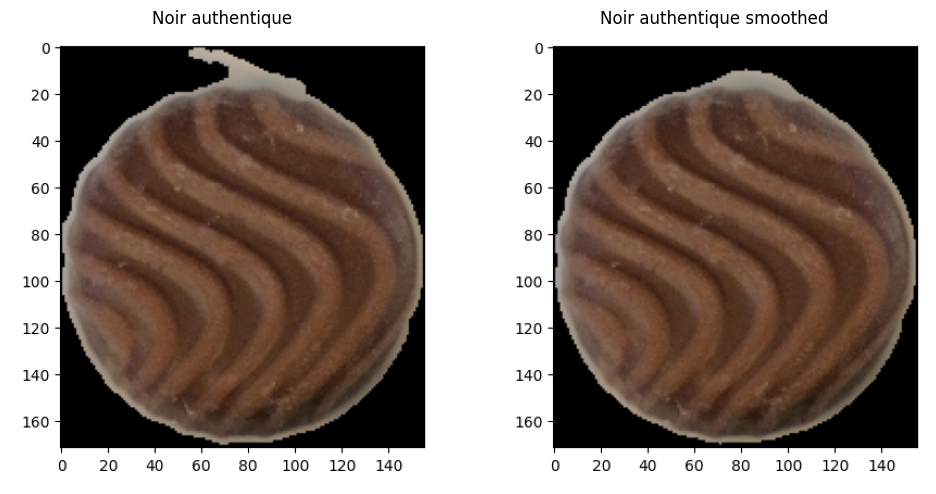

In [102]:
img_path = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/JSP OMG/images/noir authentique.png'
img_path_smooth = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/JSP OMG/images/na smoothed.png'

img = mpimg.imread(img_path)
img_smooth = mpimg.imread(img_path_smooth)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Noir authentique")
axes[1].imshow(img_smooth)
axes[1].axis('off')
axes[1].set_title("Noir authentique smoothed")

plt.tight_layout()
plt.show()

For this example, the classification was incorrect before opening and correct after.

<span style="color:orange;">Watershed</span> :

This algorithm is used to separate chocolates that are glued together. It can sometime fail to separate the chocolates in specific cases. For examples if two Triangolo's are standing next to each other side to side and not peak to peak it will fail to separate them and identify them successfully. 

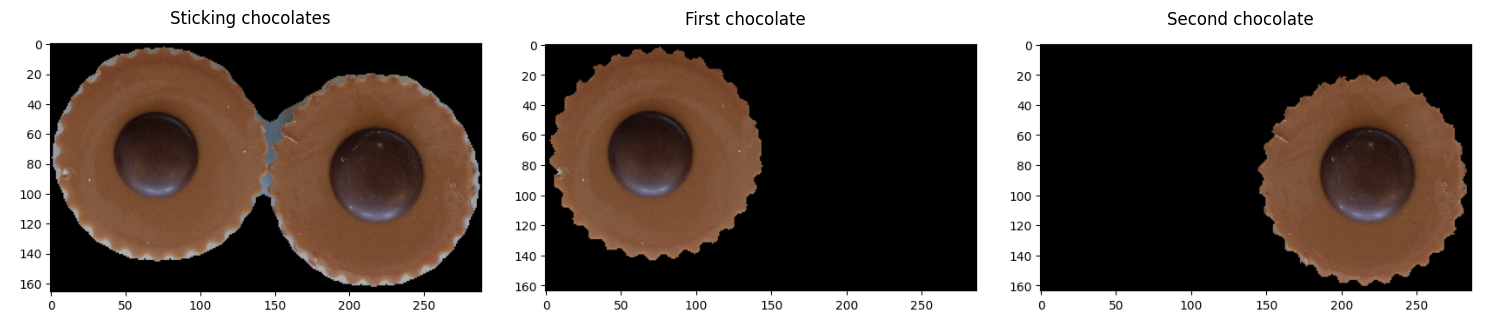

In [ ]:
img_path = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/JSP OMG/images/sticked_noblesse.png'
img_path_left = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/JSP OMG/images/left_noblesse.png'
img_path_right = 'C:/Users/miski/Desktop/Neuro-X/MA2/IAPR_50/iapr_group_50/project/JSP OMG/images/right_noblesse.png'

img = mpimg.imread(img_path)
img_left = mpimg.imread(img_path_left)
img_right = mpimg.imread(img_path_right)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Sticking chocolates")
axes[1].imshow(img_left)
axes[1].axis('off')
axes[1].set_title("First chocolate")
axes[2].imshow(img_right)
axes[2].axis('off')
axes[2].set_title("Second chocolate")

plt.tight_layout()
plt.show()

<span style="color:orange;">Various Thresholds</span> :

It happens that objects segmented cannot be chocolates because they are too large or too small. In those cases we have thresholds to ignore very large and very small objects. There is a special thresholding for objects that potentially correspond to 2 chocolates sticked together.

#### <span style="color:yellow;">Abandoned ideas :</span>

<span style="color:orange;">Weighting features in KNNs</span> : 

An idea we had was to weight the different features depending on how much they contribute to the chocolate classification. To our surprise the performance on the train set was better when not weighting the features so we abandoned this idea.

<span style="color:orange;">Random forest</span> :

Random forest is more suited if we have more training data. As we only considered the reference chocolates the data set was restricted and therefore RF was not a viable option compared to KNN.

<span style="color:orange;">Mahalanobis distance</span> :

As for RF, Mahalanobis would have been useful if the variance of the population was representative of the classes but with only one image per chocolate it was not effective so we continued with Euclidean distance.